In [11]:
# Import modules

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"   # must happen before importing jax

import argparse
import jax
import numpy as np
import numpyro
from numpyro.infer import Predictive, MCMC, NUTS
import jax.numpy as jnp
from helper import import_dataset, plot_utterance_distribution, plot_empirical_by_condition_distribution, plot_predictive_by_condition_distribution
from modelSpecification import likelihood_function_global_speaker, likelihood_function_incremental_speaker, global_speaker, incremental_speaker, incremental_semantics_jax
import matplotlib.pyplot as plt
import seaborn as sns
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
print(jax.__version__)


0.4.20


In [ ]:
# Empirical hard labels
data = import_dataset()
states_train = data["states_train"]
empirical_train = data["empirical_seq_flat"]
utterance_list = data["unique_utterances"]
empirical_dist_by_condition = data["empirical_dist_by_condition"]
df = data["df"]


print("States train shape:", states_train.shape)
print("Empirical train shape:", empirical_train.shape)
# ========================
print("States train:", states_train[0:3])
print("Empirical train:", empirical_train[0:3])

print(df["annotation"][0:3])


States train shape: (3196, 6, 3)
Empirical train shape: (3196,)
States train: [[[ 9.  1.  1.]
  [10.  0.  0.]
  [10.  0.  1.]
  [10.  0.  1.]
  [10.  0.  1.]
  [ 1.  0.  1.]]

 [[ 9.  1.  1.]
  [10.  0.  0.]
  [ 9.  0.  0.]
  [10.  0.  1.]
  [ 9.  0.  0.]
  [ 2.  0.  1.]]

 [[10.  1.  1.]
  [10.  0.  0.]
  [ 3.  1.  0.]
  [ 2.  1.  1.]
  [10.  0.  0.]
  [ 1.  0.  1.]]]
Empirical train: [5 5 2]
1      C
2      C
3    DCF
Name: annotation, dtype: category
Categories (15, object): ['C', 'CD', 'CDF', 'CF', ..., 'FC', 'FCD', 'FD', 'FDC']


Example state: [[10.  1.  1.]
 [ 9.  0.  1.]
 [ 1.  1.  1.]
 [ 2.  1.  1.]
 [ 9.  0.  1.]
 [ 2.  0.  1.]]
Example annotation_flat: 2
Example annotation: DCF
Example listener matrix shape: (15, 6)
Example listener matrix: [[0.06261043 0.07374845 0.275349   0.25727183 0.07374845 0.25727183]
 [0.04121879 0.00234377 0.6316238  0.3063464  0.00234377 0.01612349]
 [0.04121879 0.00234377 0.6316238  0.3063464  0.00234377 0.01612349]
 [0.06901827 0.08111853 0.2661213  0.25131166 0.08111853 0.25131166]
 [0.04121879 0.00234377 0.6316238  0.3063464  0.00234377 0.01612349]
 [0.3166667  0.01666667 0.3166667  0.3166667  0.01666667 0.01666667]
 [0.10155213 0.00629567 0.44660732 0.4172867  0.00629567 0.02196246]
 [0.1134764  0.00701953 0.4375434  0.41319412 0.00701953 0.02174706]
 [0.31666666 0.01666667 0.31666666 0.31666666 0.01666667 0.01666667]
 [0.10155213 0.00629567 0.44660735 0.41728675 0.00629567 0.02196246]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.06261043 0.07374

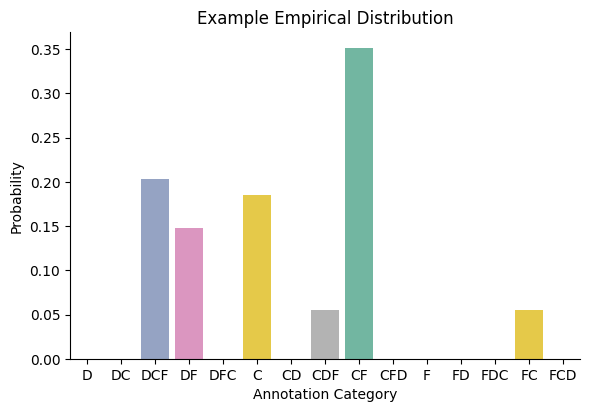

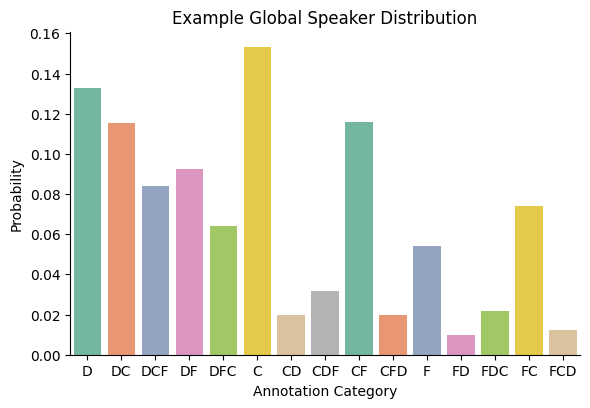

Example incremental speaker shape: [0.16853733 0.07621157 0.05538771 0.06097783 0.05126716 0.19447812
 0.01810375 0.02743671 0.10560898 0.04586205 0.06845756 0.00894518
 0.02266122 0.06753883 0.02852601]


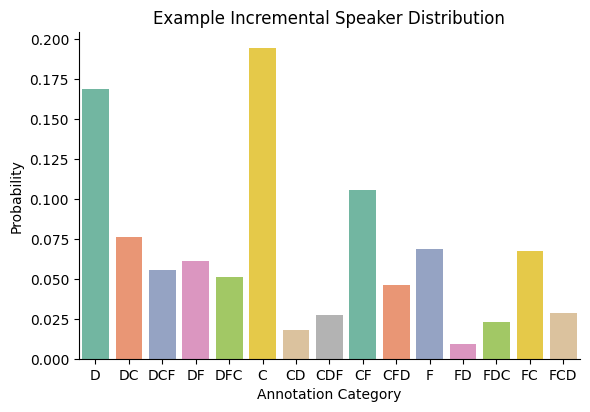

In [5]:
# Print examples
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

example_index = 3
example_state = states_train[example_index]
example_annotation_flat = empirical_train[example_index]
example_annotation = df["annotation"].iloc[example_index]
print("Example state:", example_state)
print("Example annotation_flat:", example_annotation_flat)
print("Example annotation:", example_annotation)
# plot the example empirical distribution as catplot 
# ========================




example_listener_matrix = incremental_semantics_jax(example_state, 0.95, 0.95, 0.5, 0.5)
print("Example listener matrix shape:", example_listener_matrix.shape)
print("Example listener matrix:", example_listener_matrix)
plot_utterance_distribution(empirical_dist_by_condition[example_index], titel="Example Empirical Distribution")
wf = 1
color_semval = 0.5
example_global_speaker = global_speaker(example_state, alpha=2,
                                         wf=wf, color_semval= color_semval, beta=1)
plot_utterance_distribution(example_global_speaker, titel="Example Global Speaker Distribution")
example_incremental_speaker = incremental_speaker(example_state, alpha=2, wf=wf, color_semval=color_semval, beta=1)
print("Example incremental speaker shape:", example_incremental_speaker)
plot_utterance_distribution(example_incremental_speaker, titel="Example Incremental Speaker Distribution")

In [23]:
import arviz as az
inference_data_file_path = "./inference_data/mcmc_results_global_speaker_warmup100_samples100_chains4.nc"
idata = az.from_netcdf(inference_data_file_path)
print(az.summary(idata))
idata

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha           1.948  1.293   0.114    3.777      0.620    0.309       5.0   
beta            1.317  0.281   1.066    1.792      0.135    0.070       5.0   
color_semvalue  0.874  0.075   0.800    1.000      0.036    0.020       5.0   
size_semval     0.525  1.292  -0.252    2.889      0.618    0.361       5.0   
wf              1.162  0.674   0.002    1.640      0.323    0.184       5.0   

                ess_tail  r_hat  
alpha               11.0   3.87  
beta                14.0   3.76  
color_semvalue      20.0   4.27  
size_semval         23.0   3.26  
wf                  23.0   3.26  


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## Plot prior vs posterior

array([[<Axes: >, <Axes: >, <Axes: xlabel='alpha'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='beta'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='color_semvalue'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='size_semval'>]], dtype=object)

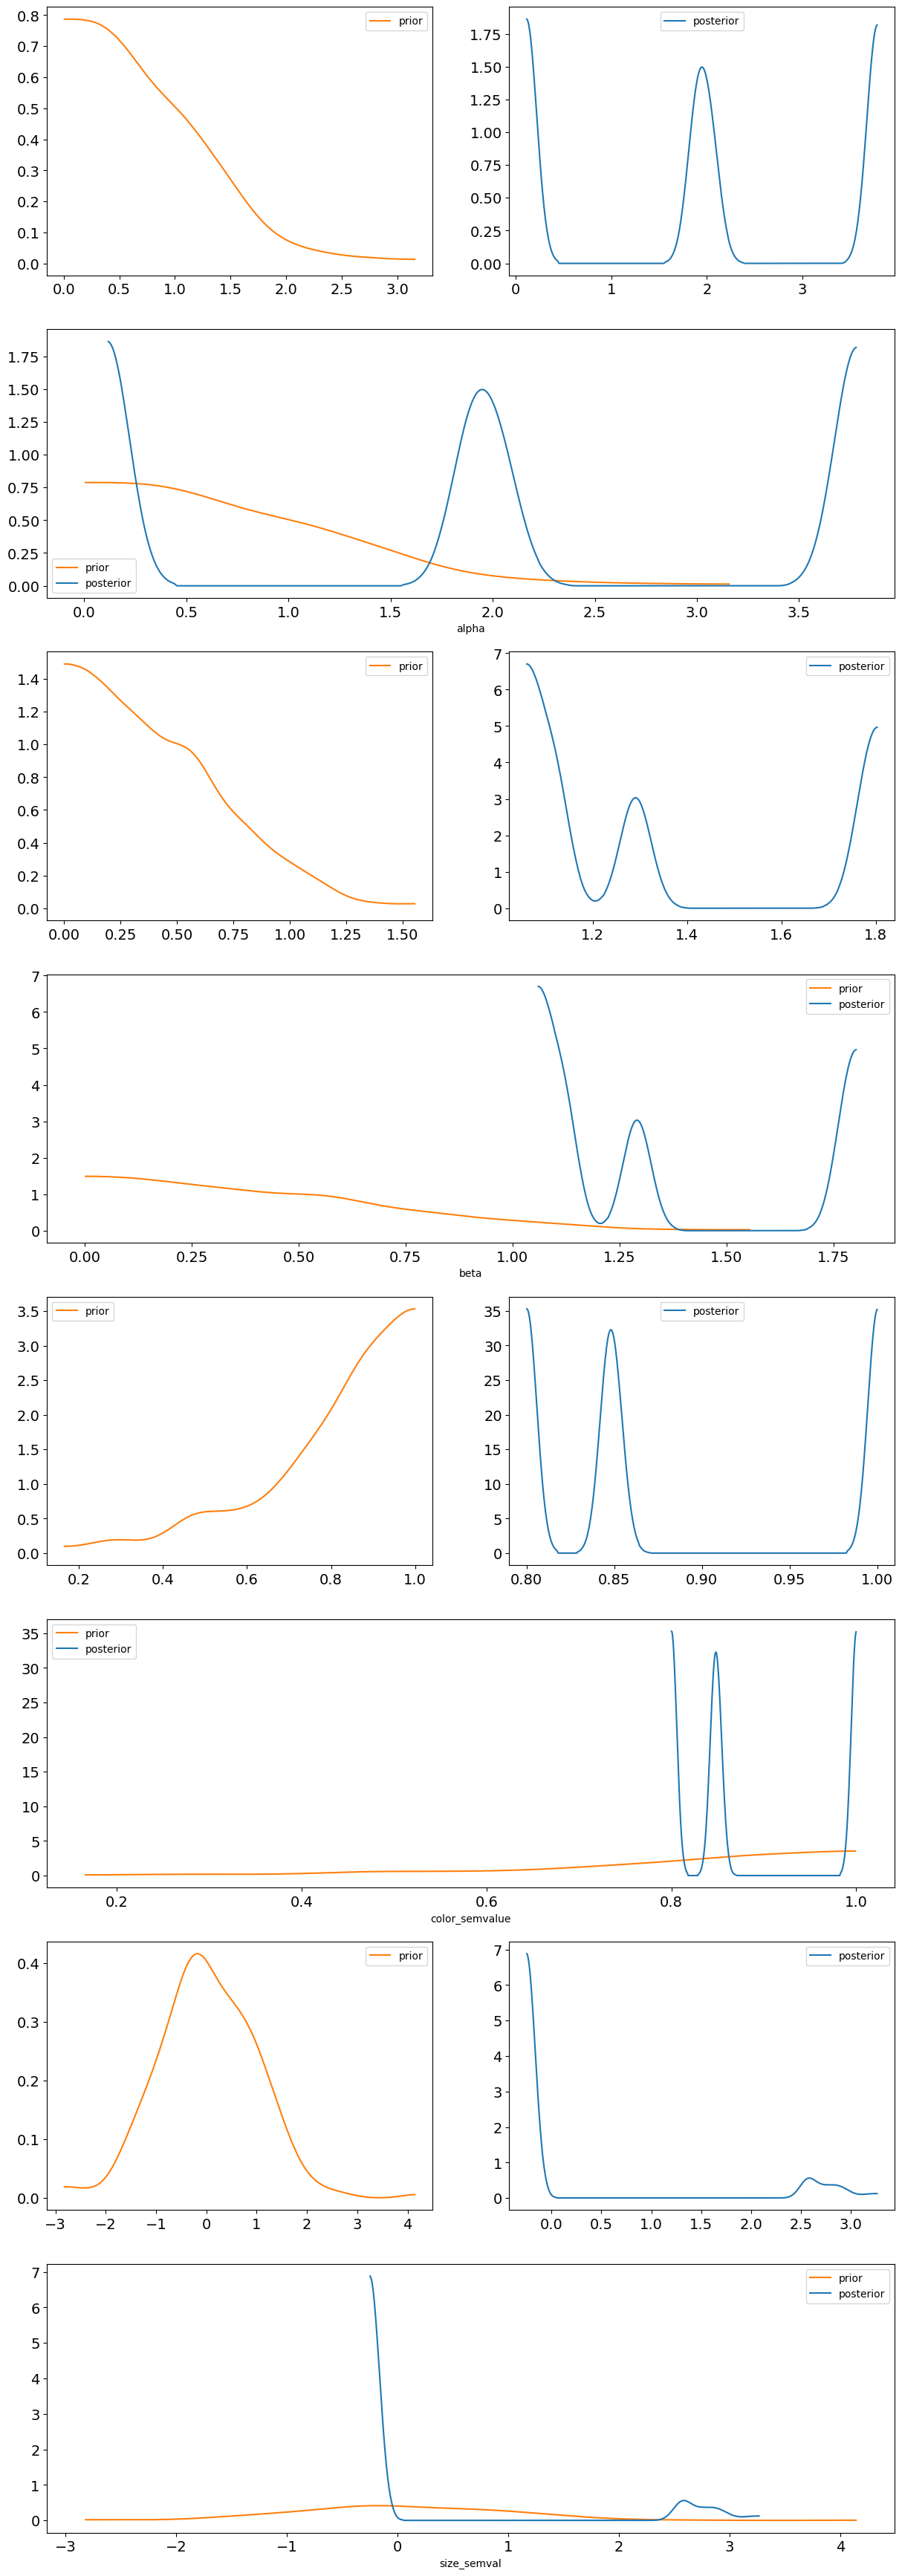

In [15]:
az.plot_dist_comparison(
    idata,
    var_names=["alpha", "beta", "color_semvalue", "size_semval"],
)

## Plot traces

/Users/heningwang/Documents/GitHub/numpyro_adjective_modelling/jax-metal/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


<xarray.Dataset> Size: 9kB
Dimensions:         (chain: 4, draw: 100)
Coordinates:
  * chain           (chain) int64 32B 0 1 2 3
  * draw            (draw) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    alpha           (chain, draw) float32 2kB 0.1144 0.1144 ... 1.892 1.891
    beta            (chain, draw) float32 2kB 1.278 1.279 1.279 ... 1.122 1.122
    color_semvalue  (chain, draw) float32 2kB 1.0 1.0 1.0 ... 0.8462 0.8462
    size_semval     (chain, draw) float32 2kB 2.52 2.526 ... -0.2277 -0.2277
    wf              (chain, draw) float32 2kB ...
Attributes:
    created_at:                 2025-11-30T15:01:07.178739+00:00
    arviz_version:              0.21.0
    inference_library:          numpyro
    inference_library_version:  0.19.0

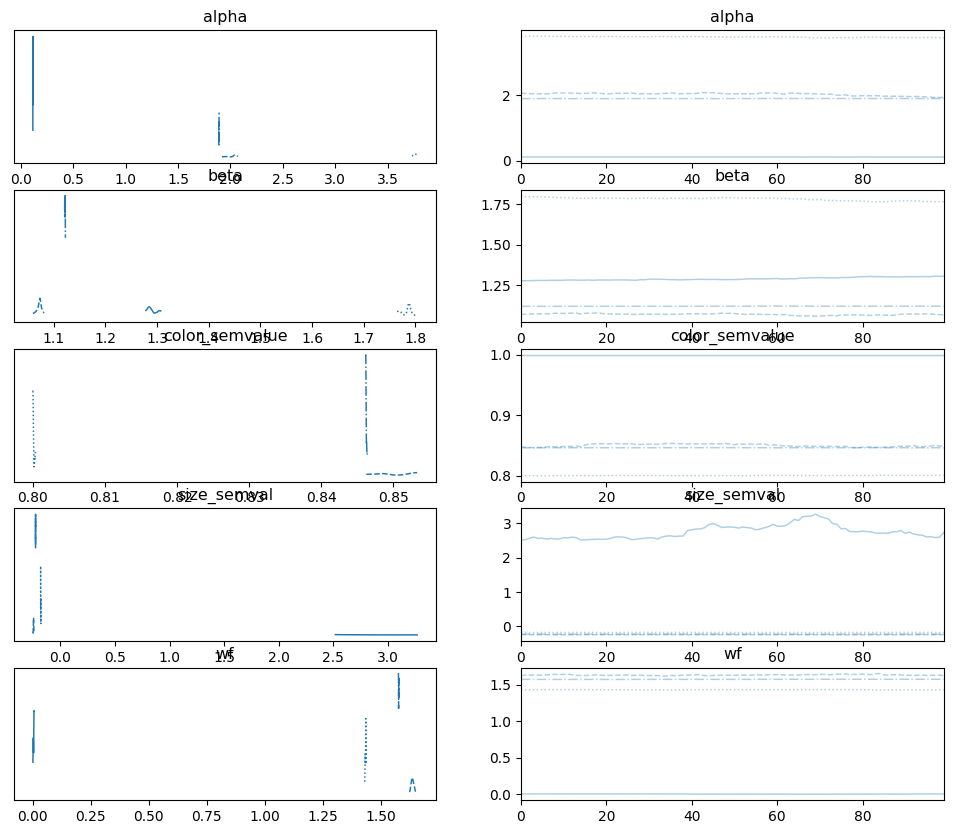

In [20]:
az.plot_trace(idata)

idata.posterior

## Plot prior predictive, empirical, and posterior predictive distribution

Empirical Distribution by Condition


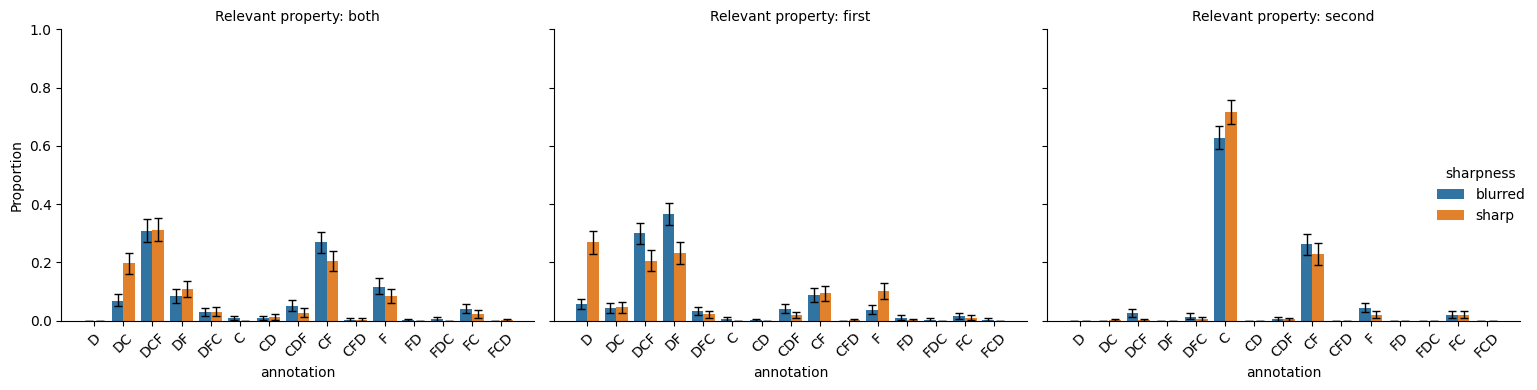

Prior Predictive Distribution by Condition


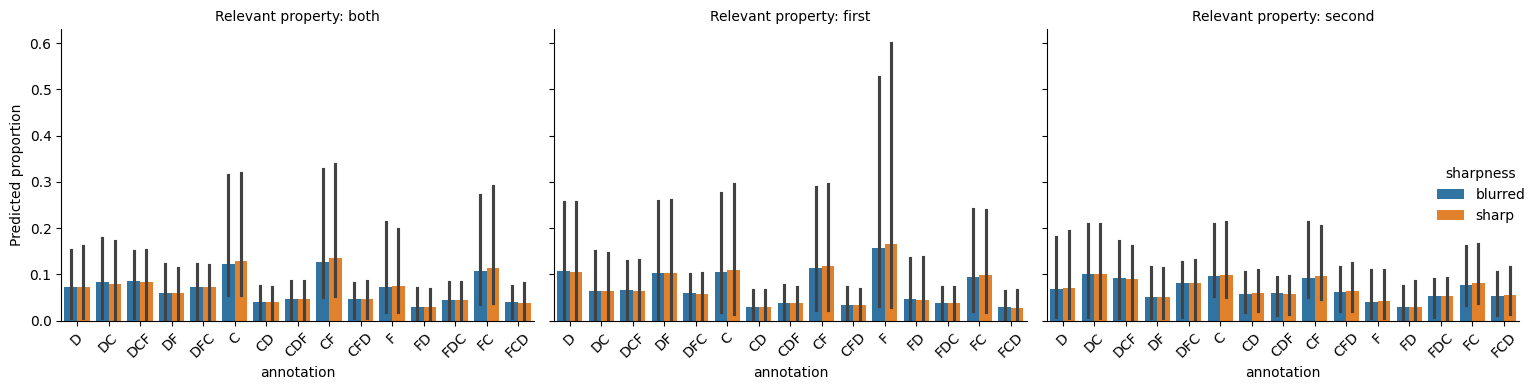

Posterior Predictive Distribution by Condition


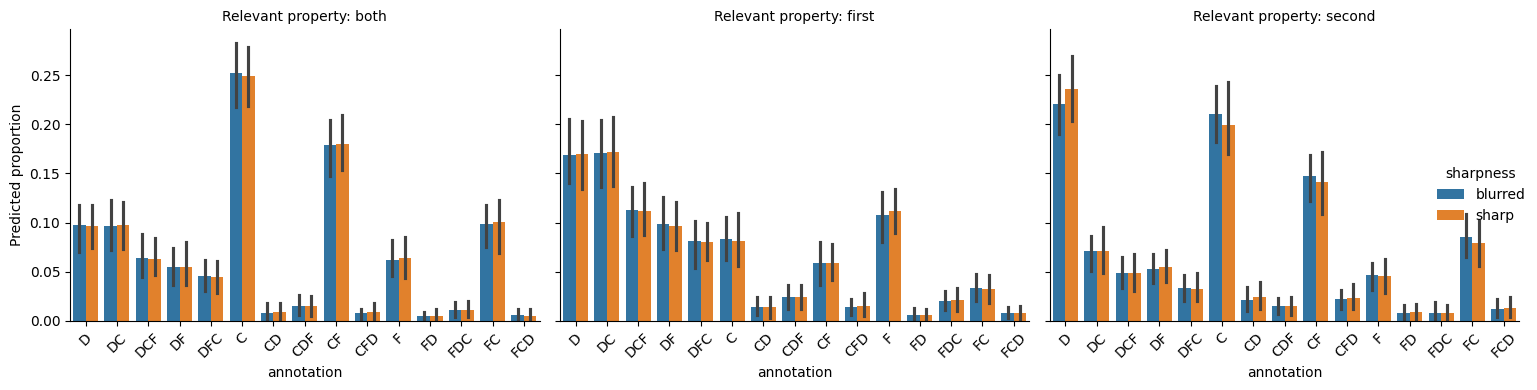

In [21]:
prior_predictive = idata.prior_predictive["obs"][0]
posterior_predictive = idata.posterior_predictive["obs"][0]

# Print titles for each plot
print("Empirical Distribution by Condition")
plot_empirical_by_condition_distribution()
print("Prior Predictive Distribution by Condition")
plot_predictive_by_condition_distribution(prior_predictive)
print("Posterior Predictive Distribution by Condition")
plot_predictive_by_condition_distribution(posterior_predictive)

In [26]:
from jax.random import PRNGKey
prior_incremental = Predictive(likelihood_function_incremental_speaker, num_samples=500)(
    PRNGKey(2), states_train
)
prior_global = Predictive(likelihood_function_global_speaker, num_samples=500)(
    PRNGKey(2), states_train
)


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.763,0.562,0.003,1.700,0.026,0.024,483.0,500.0,NaN
beta,0.423,0.307,0.000,0.976,0.016,0.010,396.0,486.0,NaN
color_semvalue,0.796,0.176,0.460,1.000,0.009,0.007,424.0,353.0,NaN
obs[0],5.752,4.036,0.000,13.000,0.185,0.091,476.0,442.0,NaN
obs[1],6.082,4.176,0.000,13.000,0.199,0.098,454.0,447.0,NaN
...,...,...,...,...,...,...,...,...,...
obs[3193],6.234,4.140,0.000,13.000,0.191,0.092,481.0,555.0,NaN
obs[3194],7.686,4.606,0.000,14.000,0.197,0.094,561.0,500.0,NaN
obs[3195],5.866,3.763,0.000,13.000,0.168,0.098,499.0,535.0,NaN
size_semval,0.029,0.944,-1.674,1.660,0.045,0.033,442.0,439.0,NaN


In [9]:
def run_inference(num_warmup = 20, num_samples = 20, speaker = None, synthetic_data = None):
    rng_key = jax.random.PRNGKey(0)
    data = import_dataset()
    empirical_train_seq_flat = data["empirical_seq_flat"]
    states_train = data["states_train"]
    if speaker == "global":
        kernel = NUTS(likelihood_function_global_speaker)
    else:
        kernel = NUTS(likelihood_function_incremental_speaker)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1)
    mcmc.run(rng_key, states=states_train, empirical=empirical_train_seq_flat)
    posterior_samples = mcmc.get_samples()
    mcmc.print_summary()
    return posterior_samples, mcmc



posterior_samples, mcmc = run_inference(num_warmup=50, num_samples=50, speaker="incremental")

def posterior_samples_analysis(posterior_samples, true_params):
    pass

def posterior_predictive_analysis(posterior_samples, synthetic_data, key):
    pass

sample: 100%|██████████| 100/100 [14:15<00:00,  8.56s/it, 7 steps of size 4.06e-01. acc. prob=0.90] 


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      2.38      0.12      2.35      2.21      2.56     13.19      0.98
            beta      1.19      0.03      1.19      1.14      1.24     16.81      0.98
  color_semvalue      0.81      0.01      0.81      0.79      0.82     17.43      0.99
     size_semval     -2.54      0.49     -2.48     -3.06     -1.76     46.44      0.98

Number of divergences: 0


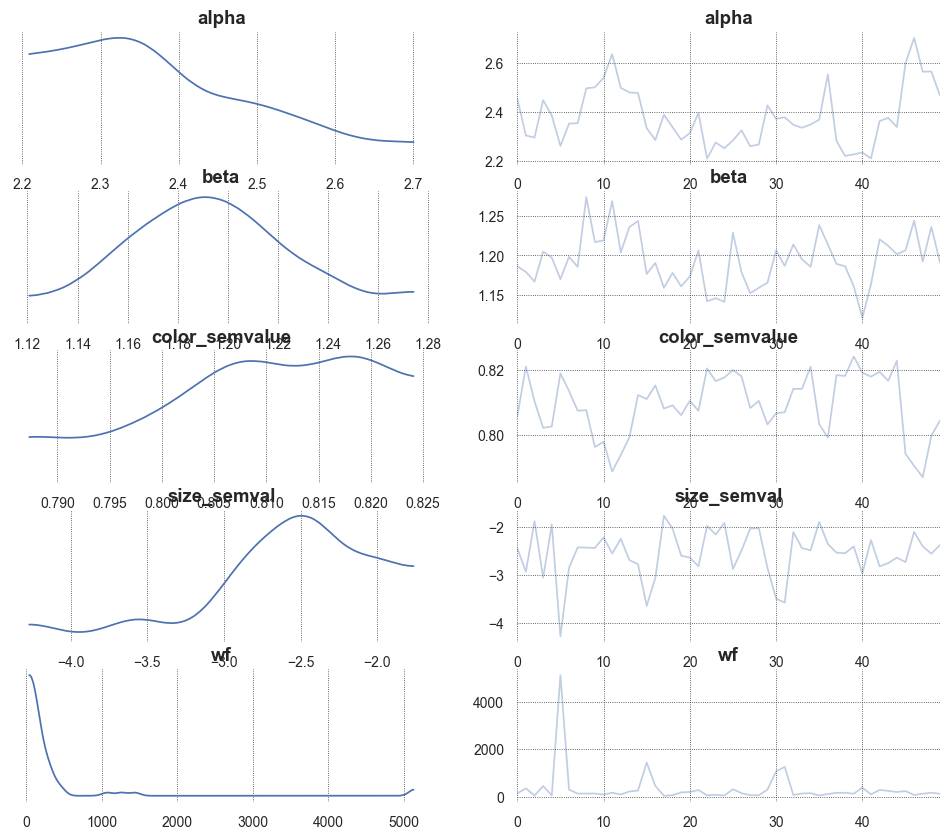

In [10]:
# Plot trace using arviz
import arviz as az
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)
plt.show()

In [12]:
from jax.random import PRNGKey
posterior_predictive = Predictive(likelihood_function_incremental_speaker, posterior_samples)(
    PRNGKey(1), states_train
)
prior = Predictive(likelihood_function_incremental_speaker, num_samples=500)(
    PRNGKey(2), states_train
)   

numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"states": np.arange(states_train.shape[0])},
    dims={"theta": ["states"]},
)

In [22]:
predictions = idata.posterior_predictive["obs"][0]

#collasped to 2 dimension
predictions.shape

summary = summarize_predictions(predictions, df, annotation_map=FLAT_TO_CATEGORIES)